In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import atlas_mpl_style
import colorsys
import numpy as np
atlas_mpl_style.use_atlas_style(fancyLegend=True)

In [60]:
################################################################
###                          INPUTS                          ###
###                                                          ###
### Edit the `vals` and `styles` variables with your data    ###
### and configuration                                        ###
###                                                          ###
################################################################

# A dictionary of group:data, with each entry corresponding to a group of bars
# in top to bottom order. The group name is shown on the y-label. 
# 
# `data` should be a dictionary containing entries collider:[limit, reference], 
# in top to bottom order. `limit` can also be a tuple (min, mid, max) to show a range. 
# 
# `data` can also have optional entries 
#       - 'annotation': An annotation is added to the group label
#       - 'current limits': A value for the current limit, which is drawn as a vertical bar
vals = {
    '2-body': {
        'HL-LHC': [1.7, 'ATL-PHYS-PUB-2018-021'],
        'FCC-hh': [10.8, 'CERN-ACC-2018-0056'],
        'ILC': [0.25, '$\\sqrt{s}/2$'],
        'CLIC': [1.5, '$\\sqrt{s}/2$'],
        'annotation': r'$\widetilde{t}_1 \to t\widetilde{\chi}_1^0$',
        'current limits': 1.25,
    },
    '3-body': {
        'HL-LHC': [0.85, 'ATL-PHYS-PUB-2018-021'],
        'FCC-hh': [10, 'CERN-ACC-2018-0056'],
        'ILC': [0.25, '~$\\sqrt{s}/2$'],
        'CLIC': [1.5, '~$\\sqrt{s}/2$'],
        'annotation': r'$\widetilde{t}_1 \to bW\widetilde{\chi}_1^0$',
        'current limits': 0.75,
    },
    '4-body': {
        'HL-LHC': [0.95, 'ATL-PHYS-PUB-2018-021'],
        'FCC-hh': [5, 'CERN-ACC-2019-0036'],
        'ILC': [0.25, '~$\\sqrt{s}/2$'],
        'CLIC': [1.5, '~$\\sqrt{s}/2$'],
        'annotation': r"$\widetilde{t}_1 \to bff'\widetilde{\chi}_1^0$",
        'current limits': 0.625,
    },
    'Precision\nHiggs': {
        'FCC-ee': [1, '1707.03399'],
        'CEPC': [0.8, '1707.03399'],
    },
}


# A dictionary of collider:styles, where the colliders correspond to those
# in `vals`. The order here is the order they appear in the legend. Styles 
# is a dictionary of options to Axes.barh. You can optionally also include 
# a style option 'annotation':annotation, which will append the annotation 
# to the legend description. 
# 
# Note that an option, if used, must be specified for all colliders. 
#
# https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.axes.Axes.barh.html
cmap = mcm.get_cmap('Set3')
styles = {
    'HL-LHC': {'annotation':'14 TeV, 3 ab$^{-1}$', 'color':cmap(0), 'hatch':None},
    'FCC-hh': {'annotation':'100 TeV, 30 ab$^{-1}$', 'color':cmap(7), 'hatch':'/'},
    'ILC': {'annotation':'0.5 TeV, 4 ab$^{-1}$', 'color':cmap(3), 'hatch':'-'},
    'CLIC': {'annotation':'3 TeV, 5 ab$^{-1}$', 'color':cmap(4), 'hatch':'|'},
    'FCC-ee': {'annotation':'0.35 TeV, 12.6 ab$^{-1}$', 'color':cmap(2), 'hatch':'+'},
    'CEPC': {'annotation':'0.24 TeV, 10 ab$^{-1}$', 'color':cmap(5), 'hatch':'x'},
}

xlabel = r'$m(\widetilde{t}_1)$ [GeV]'

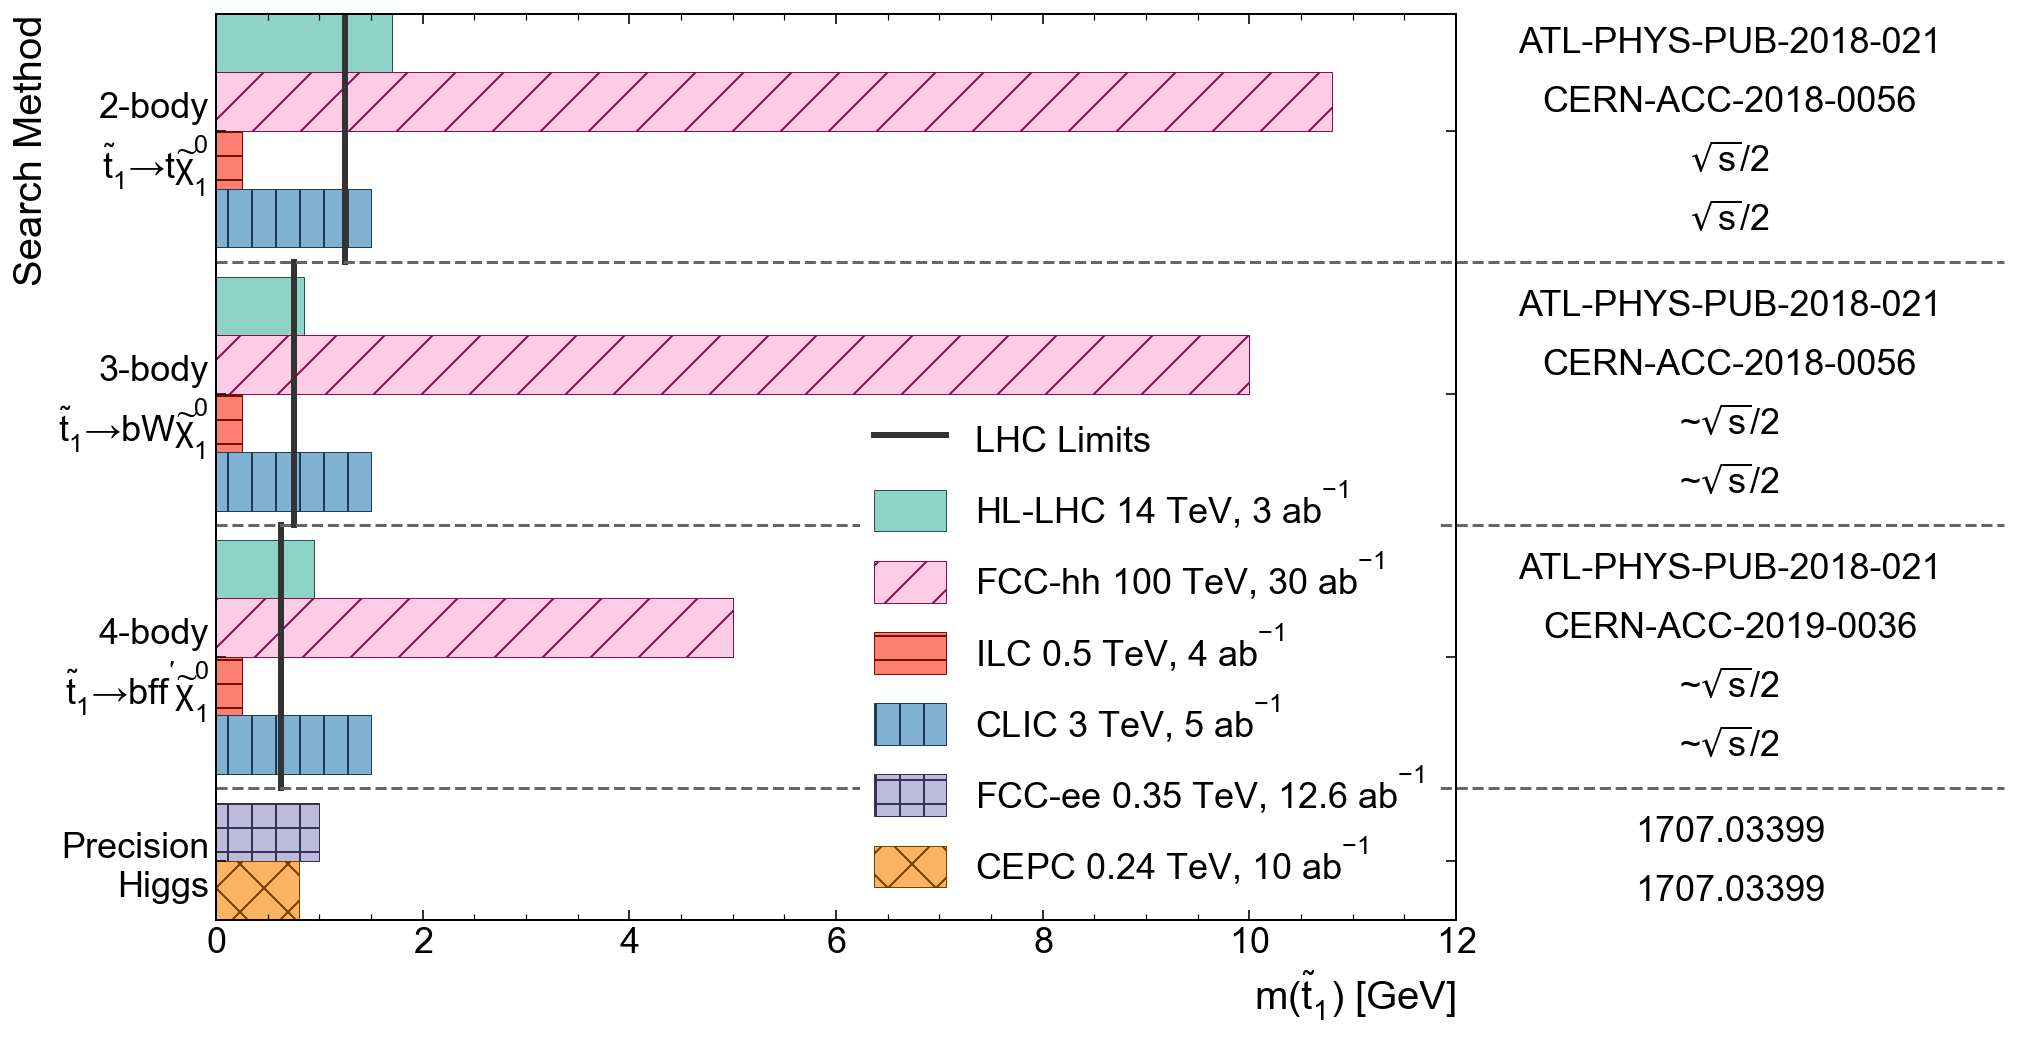

In [63]:
################################################################
###                           PLOT                           ###
###                                                          ###
### You hopefully don't need to edit this block, but further ###
### customization can be hardcoded here.                     ###
###                                                          ###
################################################################

### Setup and collections ###
fig, ax = plt.subplots()
fig.set_dpi(144)

bar_height = 1 # height of a bar in data coordinates (keep this at 1)
group_pad = 0.5 # space between groups in data coordinates
reference_pad = 0.05 # in axes coordinates

# y-groups (search method)
labels = [] # string labels for each group
label_ys = [] # y position of the labels
dividers = [] # y positions of where to draw dividers between the groups
curr_lims = [] # (x, y0, y1) positions of the current limits

# bars
ys = [] # y position of each bar (lower edge)
widths = [] # width of each bar
references = [] # string reference of each bar
ranges = [] # list of (y, xmin, xmax) of where to plot a hatching indicating a range of values
opts = {} # option : list per bar

# legend
legend_indexes = {} # collider : index into bars.patches

### Collate info ###
y = 0 # Loop from top to bottom (y-axis will be inverted, so start at y=0 and go up).
for i,(group,colliders) in enumerate(vals.items()):
    y_group_start = y

    ### Collider bars ###
    for collider,limits in colliders.items():
        if collider in ['annotation', 'current limits']:
            continue
        if hasattr(limits[0], '__getitem__'): # plot a range
            widths.append(limits[0][1])
            ranges.append((y, limits[0][0], limits[0][2]))
        else:
            widths.append(limits[0])
        references.append(limits[1])
        ys.append(y)
        for opt,opt_val in styles[collider].items():
            if opt != 'annotation':
                opts.setdefault(opt, []).append(opt_val)
        legend_indexes.setdefault(collider, len(ys) - 1)
        y += bar_height

    ### Group info ###
    if annotation := colliders.get('annotation'):
        group += '\n' + annotation
    labels.append(group)
    label_ys.append((y + y_group_start) / 2)
    dividers.append(y + group_pad / 2)
    if lim := colliders.get('current limits'):
        curr_lims.append((lim, 0 if len(dividers) < 2 else dividers[-2], y if i == len(vals) - 1 else dividers[-1]))
    y += group_pad
dividers = dividers[:-1] # don't draw a divider after the last group

### Auto-set hatch color ###
def darken(c, value=3):
    rgba = mcolors.to_rgba(c)
    h,l,s = colorsys.rgb_to_hls(*rgba[:3])
    new_rgb = colorsys.hls_to_rgb(h, min(1, l/value), s)
    return [*new_rgb, rgba[3]]
if 'color' in opts and 'hatch' in opts and 'edgecolor' not in opts:
    opts['edgecolor'] = [darken(c) for c in opts['color']]

### Plot main bars ###
bars = ax.barh(ys, widths, height=bar_height, align='edge', **opts)
ax.set_yticks(label_ys, labels)
ax.tick_params(axis='y', which='minor', left=False, right=False)
ax.set_ylim(0, ys[-1] + bar_height)
ax.invert_yaxis()
atlas_mpl_style.set_xlabel(xlabel)
atlas_mpl_style.set_ylabel("Search Method")

### Plot range overlays ###
for y,x0,x1 in ranges:
    patch_range = mpatches.Rectangle((x0, y), x1 - x0, bar_height, hatch='////', linestyle='', edgecolor='#00000077', fill=False)
    ax.add_patch(patch_range)

### Plot current limits ###
for x,y0,y1 in curr_lims:
    lim_line = ax.plot([x, x], [y0, y1], linestyle='-', linewidth=3, color='#333333')

### Plot and get x extent of references ###
x0,x1 = ax.get_xlim()
max_text_width = 0 # in axes coordinates
patch_references = []
for y,ref in zip(ys, references):
    t = ax.text(x1, y + bar_height/2, ref, va='center', ha='center')
    bb = t.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
    max_text_width = max(max_text_width, bb.x1 - bb.x0)
    patch_references.append(t)
    # https://stackoverflow.com/questions/24581194/matplotlib-text-bounding-box-dimensions
data_to_axis = ax.transData + ax.transAxes.inverted()
for patch in patch_references: # adjust x position
    pos = list(data_to_axis.transform(patch.get_position())) # axis coordinates, with x = 1 currently
    pos[0] += reference_pad + max_text_width / 2
    pos = data_to_axis.inverted().transform(pos)
    patch.set_position(pos)

### Plot dividers ###
for y in dividers:
    ax.axhline(y, xmax=1 + 2 * reference_pad + max_text_width, linestyle='--', color='#666666', clip_on=False)

### Plot legend ###
legend_patches = [lim_line[0]]
legend_labels = ['LHC Limits']
for collider,opts in styles.items():
    if (index := legend_indexes.get(collider)) is not None:
        legend_patches.append(bars.patches[index])
        if annotation := opts.get('annotation'):
            collider += ' ' + annotation
        legend_labels.append(collider)
if ranges:
    legend_patches.append(patch_range)
    legend_labels.append('Range of estimates')
legend = ax.legend(legend_patches, legend_labels, framealpha=1, edgecolor='white', handleheight=1.4)


In [57]:
################################################################
###                           SAVE                           ###
################################################################
#fig.savefig('stop.png', dpi=144, bbox_inches="tight", facecolor='w')